## <span style="color:#db7d60">Setup</span>

In [1]:
%load_ext autoreload
%autoreload 2

import json
import math
import pickle
import numpy as np
import pandas as pd
import textwrap
import sys
from pathlib import Path
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

# pUtil needs to be loaded from the root directory
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

import pUtil
from analysis_common import *
import data_manager
import analysis as anal

import vector
from particle import Particle
from particle import PDGID

plt.rcParams['figure.figsize'] = (21, 6)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

/global/homes/e/eshy/.local/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


## <span style="color:#db7d60">Analysis</span>

In [2]:
model_name = 'model_5_9_1'
input_leading_path = pUtil.get_model_preparation_dir(model_name) / 'real_leading_test_particles.csv'

columns = ["num_particles", "pdgid", "e", "px", "py", "pz", "pt", "eta", "theta", "phi"]
real_df = pd.read_csv(input_leading_path, sep=" ", names=columns, engine="c", header=None)

Testing gaussian binning for phi. This is the best result from all of the eta tests.

In [25]:
from scipy.stats import norm
from scipy.interpolate import interp1d

# Basic median centered gaussian spacing
def simple_gaussian_space(start, stop, num, scale=1.0):
    """
    Create a grid that is densest at the center and more sparse at the ends,
    mimicking a Gaussian profile.

    Parameters:
        start (float): Lower bound of output range.
        stop (float): Upper bound of output range.
        num (int): Number of bins or points.
        scale (float): Controls sharpness; higher = sharper peak at center.

    Returns:
        numpy.ndarray: Array with center-dense, tail-sparse spacing.
    """
    # linspace from 0 to 1, but exclude exact 0 and 1 to avoid ±inf
    probs = np.linspace(1e-6, 1 - 1e-6, num)
    # Use inverse Gaussian CDF (symmetric bell shape)
    z = norm.ppf(probs)  # in [-inf, inf], centered at 0
    z = z / np.max(np.abs(z))  # normalize to [-1, 1]
    z = 0.5 + 0.5 * z / scale  # shrink to [0, 1] range
    return start + (stop - start) * np.clip(z, 0, 1)
    
# More advanced Gaussian spacing with peak control
def gaussian_space(start, stop, num, center, sigma=1.0):
    """
    Generate a Gaussian-spaced array of points between start and stop,
    with the highest density of points near `center`.

    Parameters:
        start (float): Start of range.
        stop (float): End of range.
        num (int): Number of points to generate.
        center (float): Location where spacing is most dense.
        sigma (float): Controls sharpness of peak (standard deviation of Gaussian).

    Returns:
        np.ndarray: Array of values spaced according to a Gaussian profile.
    """
    # Create a fine-grained range to define the target density
    x_fine = np.linspace(start, stop, 10_000)
    pdf = norm.pdf(x_fine, loc=center, scale=sigma)
    cdf = np.cumsum(pdf)
    cdf = (cdf - cdf.min()) / (cdf.max() - cdf.min())  # normalize to [0, 1]

    # Invert CDF: get target values from uniform
    inv_cdf = interp1d(cdf, x_fine, bounds_error=False, fill_value=(start, stop))
    uniform_probs = np.linspace(0, 1, num)
    return inv_cdf(uniform_probs)

# Detokenization of gaussian bins using bin medians
def detokenize_gaussian_bins(tokens, bin_edges):
    """
    Decode tokenized values back to approximate original values
    using bin centers.

    Parameters:
        tokens (np.ndarray): Array of token indices (0-based).
        bin_edges (np.ndarray): Bin edges used during digitization.

    Returns:
        np.ndarray: Decoded values.
    """
    # Bin centers: len = len(bin_edges) + 1 - 1 = len(bin_edges)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    # Clip tokens to valid range
    tokens = np.clip(tokens, 0, len(bin_centers) - 1)
    return bin_centers[tokens]

# Helper for detokenization of gaussian bins using bin means
def build_bin_means(values, bin_edges):
    bin_indices = np.digitize(values, bin_edges[1:-1], right=True)  # tokens range from 0 to len(bin_edges) - 2
    num_bins = len(bin_edges) - 1  # Number of actual bins
    bin_means = np.zeros(num_bins)
    for i in range(num_bins):
        in_bin = values[bin_indices == i]
        if len(in_bin) > 0:
            bin_means[i] = in_bin.mean()
        else:
            bin_means[i] = 0.5 * (bin_edges[i] + bin_edges[i + 1])
    return bin_means

real_phi = real_df['phi'].values

# Linear tokenized eta with 8000 bins for visual comparisons
granular_shifted_phi_bins = np.linspace(-np.pi, np.pi, 8000)
tokenized_granular_real_phi = np.digitize(real_phi, bins=granular_shifted_phi_bins)
tokenized_granular_real_phi_freq = Counter(tokenized_granular_real_phi)
full_tokenized_freq = {i: 0 for i in range(0, 100)}
full_tokenized_freq.update(tokenized_granular_real_phi_freq)
tokenized_granular_real_phi_freq = sorted(full_tokenized_freq.items(), key=lambda x: x[0])

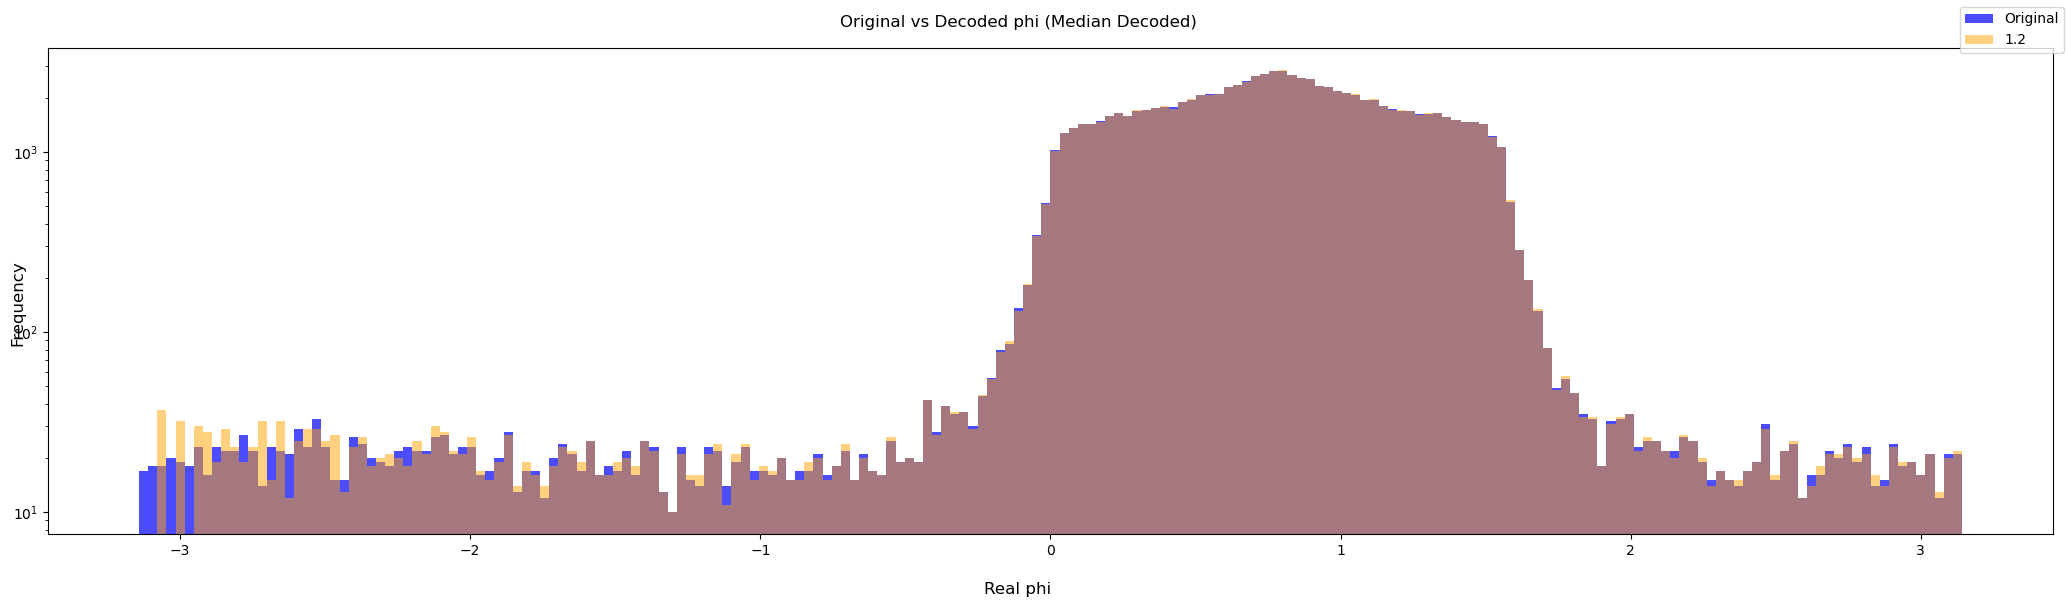

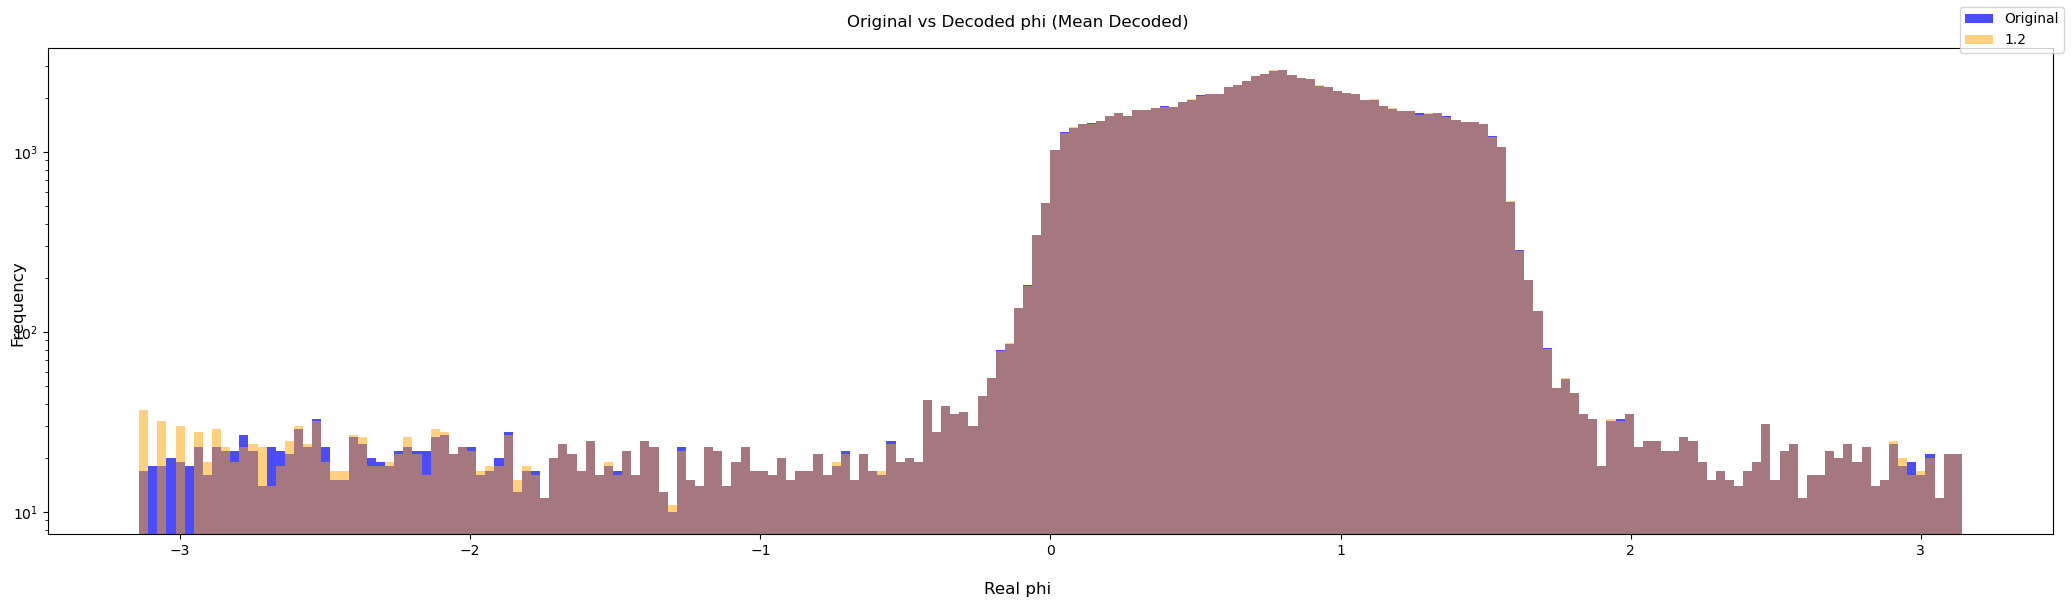

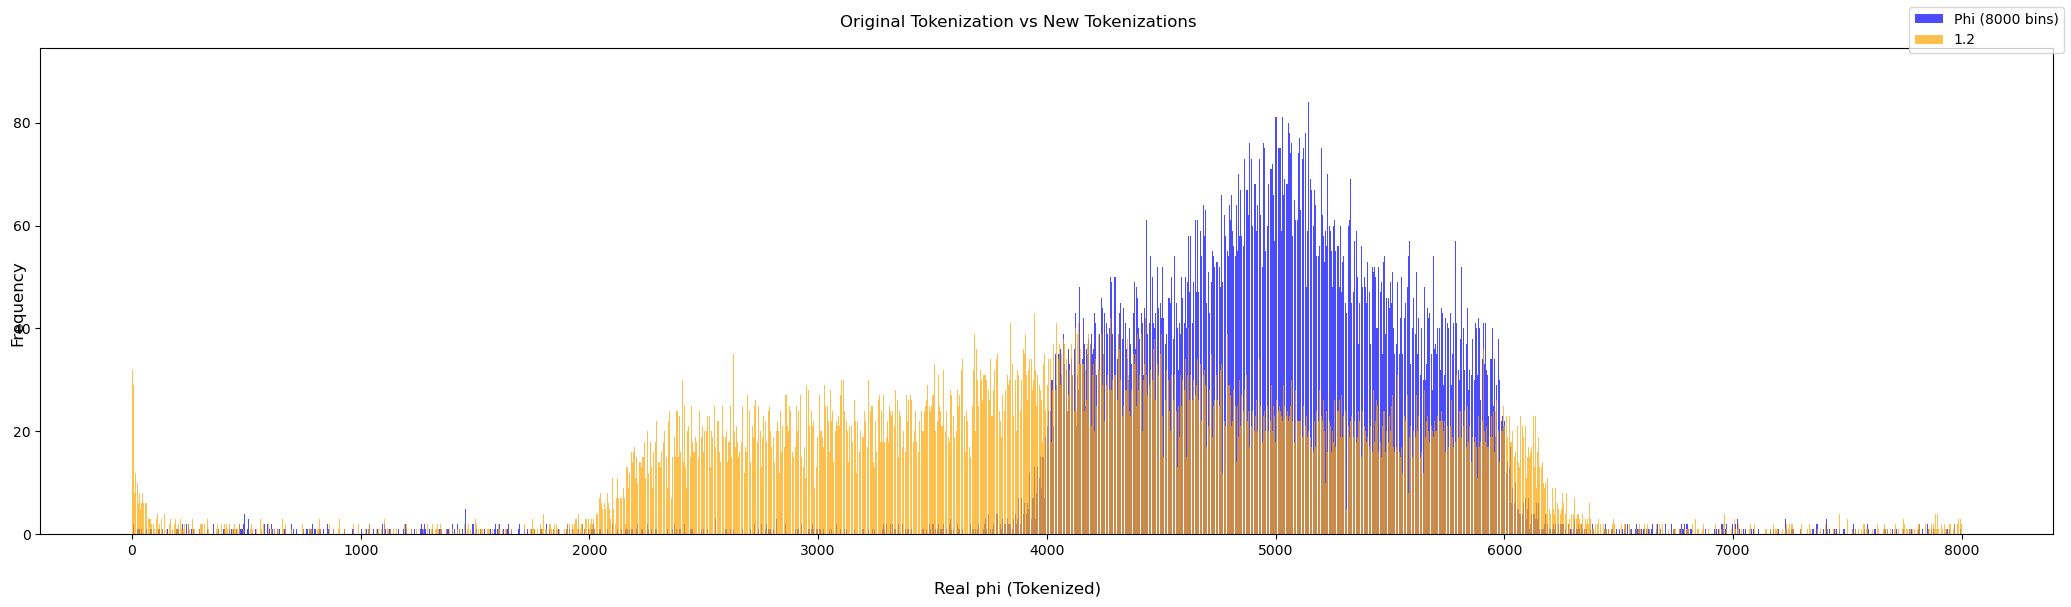

In [26]:

med_val_fig, med_val_ax = plt.subplots()
med_val_fig.suptitle("Original vs Decoded phi (Median Decoded)")
med_val_fig.supxlabel("Real phi")
med_val_fig.supylabel("Frequency")
med_val_ax.set_yscale('log')
med_val_ax.hist(real_phi, range=(-np.pi, np.pi), bins=200, label="Original", color=anal.plotting.colors[0], alpha=0.7)

mean_val_fig, mean_val_ax = plt.subplots()
mean_val_fig.suptitle("Original vs Decoded phi (Mean Decoded)")
mean_val_fig.supxlabel("Real phi")
mean_val_fig.supylabel("Frequency")
mean_val_ax.set_yscale('log')
mean_val_ax.hist(real_phi, range=(-np.pi, np.pi), bins=200, label="Original", color=anal.plotting.colors[0], alpha=0.7)

tok_fig, tok_ax = plt.subplots()
tok_fig.suptitle("Original Tokenization vs New Tokenizations")
tok_fig.supxlabel("Real phi (Tokenized)")
tok_fig.supylabel("Frequency")
tok_ax.bar(dict(tokenized_granular_real_phi_freq).keys(), dict(tokenized_granular_real_phi_freq).values(), label=f'Phi (8000 bins)', color=anal.plotting.colors[0], alpha=0.7)

for idx, sig in enumerate([1.2]):
    n_gaussian_shifted_phi_bins = 8000
    gaussian_shifted_phi_bins = gaussian_space(-np.pi, np.pi, n_gaussian_shifted_phi_bins, 0.75, sigma=sig)
    gaussian_bin_tokenized_shifted_phi = np.digitize(real_phi, bins=gaussian_shifted_phi_bins)
    gaussian_bin_tokenized_shifted_phi_freq = Counter(gaussian_bin_tokenized_shifted_phi)
   
        
    # Bin meadian
    median_decoded_phi = detokenize_gaussian_bins(gaussian_bin_tokenized_shifted_phi, gaussian_shifted_phi_bins)

    # Bin mean
    bin_means = build_bin_means(real_phi, gaussian_shifted_phi_bins)
    _tokens = np.digitize(real_phi, gaussian_shifted_phi_bins[1:-1], right=True)
    _tokens = np.clip(_tokens, 0, len(bin_means) - 1)
    mean_decoded_phi = bin_means[_tokens]
    
    med_val_ax.hist(median_decoded_phi, range=(-np.pi, np.pi), bins=200, label=f'{sig}', color=anal.plotting.colors[idx + 1], alpha=0.5)
    mean_val_ax.hist(mean_decoded_phi, range=(-np.pi, np.pi), bins=200, label=f'{sig}', color=anal.plotting.colors[idx + 1], alpha=0.5)
    tok_ax.bar(dict(gaussian_bin_tokenized_shifted_phi_freq).keys(), dict(gaussian_bin_tokenized_shifted_phi_freq).values(), label=f'{sig}', color=anal.plotting.colors[idx + 1], alpha=0.7)
    
med_val_fig.legend()
med_val_fig.tight_layout()
med_val_fig.show()
mean_val_fig.legend()
mean_val_fig.tight_layout()
mean_val_fig.show()
tok_fig.legend()
tok_fig.tight_layout()
tok_fig.show()